# IBM Quantum Challenge 2020 - Final Challenge

Solution by Stefan Hillmich ([Johannes Kepler University Linz](https://iic.jku.at/eda/team/hillmich/) and [LinkedIn](https://www.linkedin.com/in/stefan-hillmich/))

Asteroids is a famous puzzle with the following setup and rules:
- The asteroids are placed on a grid.
- The objective is to destroy all the asteroids by shooting laser beams: either vertically or horizontally.
- Determine how to destroy all the asteroids by shooting no more than the specified number of beams.

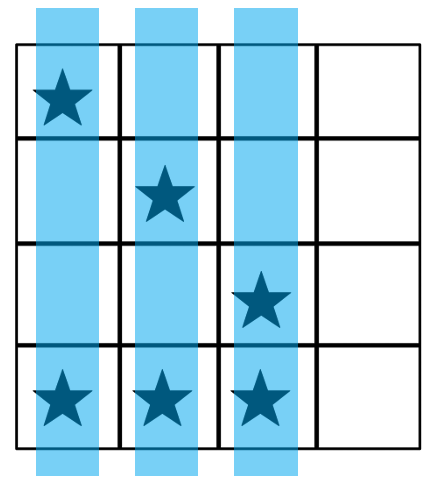

## Imports

The following imports from Qiskit and SymPy are used to solve the challenge. Note that Sympy is a dependency of Qiskit.

In [16]:
from qiskit.qasm import pi
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import U2Gate, U1Gate, CXGate, CU1Gate, U3Gate, HGate, TGate, TdgGate
from sympy.combinatorics.graycode import GrayCode
from sympy.utilities.iterables import multiset_permutations

## Utility Functions

Qiskit readily provides functions for phase-relative gates [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.rccx) and [RCCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.rcccx), however, these implementations do contain multiple single-qubit gates that can be fused. The following functions therefore help reduce the cost by a bit. The decomposition of the fused gates are given in the comments.

In [23]:
def my_rccx(qc: QuantumCircuit, q0, q1, q2):
    """Taken from qiskit and optimized. Cost 3*10 + 4 = 34"""
    rules = [
        (U2Gate(pi/4, pi),  [q2], []),  # -H-T-
        (CXGate(),      [q1, q2], []),
        (U1Gate(-pi / 4),   [q2], []),  # -Tdg-
        (CXGate(),      [q0, q2], []),
        (U1Gate(pi / 4),    [q2], []),  # -T-
        (CXGate(),      [q1, q2], []),
        (U2Gate(0, 3*pi/4), [q2], []),  # -Tdg-H-
    ]
    for instr, qargs, cargs in rules:
        qc.append(instr, qargs, cargs)


def my_drccx(qc: QuantumCircuit, qa, qb, qab, qtarget):
    """Two RCCX gate with the same target and one shared control can be build more efficiently 
    than two stand-alone RCCX gates. Cost 4*10 + 4 = 44"""
    qc_ = QuantumCircuit(4, name='drccx')
    rules = [
        (U2Gate(pi/4, pi),     [3], []),  # -H-T-
        (CXGate(),          [2, 3], []),
        (U1Gate(-pi / 4),      [3], []),  # -Tdg-
        (CXGate(),          [0, 3], []),
        (CXGate(),          [1, 3], []),
        (U1Gate(pi / 4),       [3], []),  # -T-
        (CXGate(),          [2, 3], []),
        (U2Gate(0, 3*pi/4),    [3], []),  # -Tdg-H-
    ]
    for instr, qargs, cargs in rules:
        qc_.append(instr, qargs, cargs)
    qc.append(qc_.to_gate(), [qa, qb, qab, qtarget], [])


def my_rcccx(qc: QuantumCircuit, q0, q1, q2, q3):
    """Taken from qiskit and optimized. Cost 6*10 + 7 = 67"""
    rules = [
        (U2Gate(pi / 4, pi),           [q3], []),  # -H-T-
        (CXGate(),                 [q2, q3], []),
        (U2Gate(0, 3 * pi / 4),        [q3], []),  # -Tdg-H-
        (CXGate(),                 [q0, q3], []),
        (U1Gate(pi / 4),               [q3], []),  # -T-
        (CXGate(),                 [q1, q3], []),
        (U1Gate(-pi / 4),              [q3], []),  # -Tdg-
        (CXGate(),                 [q0, q3], []),
        (U1Gate(pi / 4),               [q3], []),  # -T-
        (CXGate(),                 [q1, q3], []),
        (U3Gate(pi/2, pi / 4, 3*pi/4), [q3], []),  # -Tdg-H-T-
        (CXGate(),                 [q2, q3], []),
        (U2Gate(0, 3 * pi / 4),        [q3], []),  # -Tdg-H-
    ]

    for instr, qargs, cargs in rules:
        qc.append(instr, qargs, cargs)

## Diffusion

This is the standard diffusion for Grover's search with the exception of a layer of `X` gates (from the QRAM) prepended to merge them.

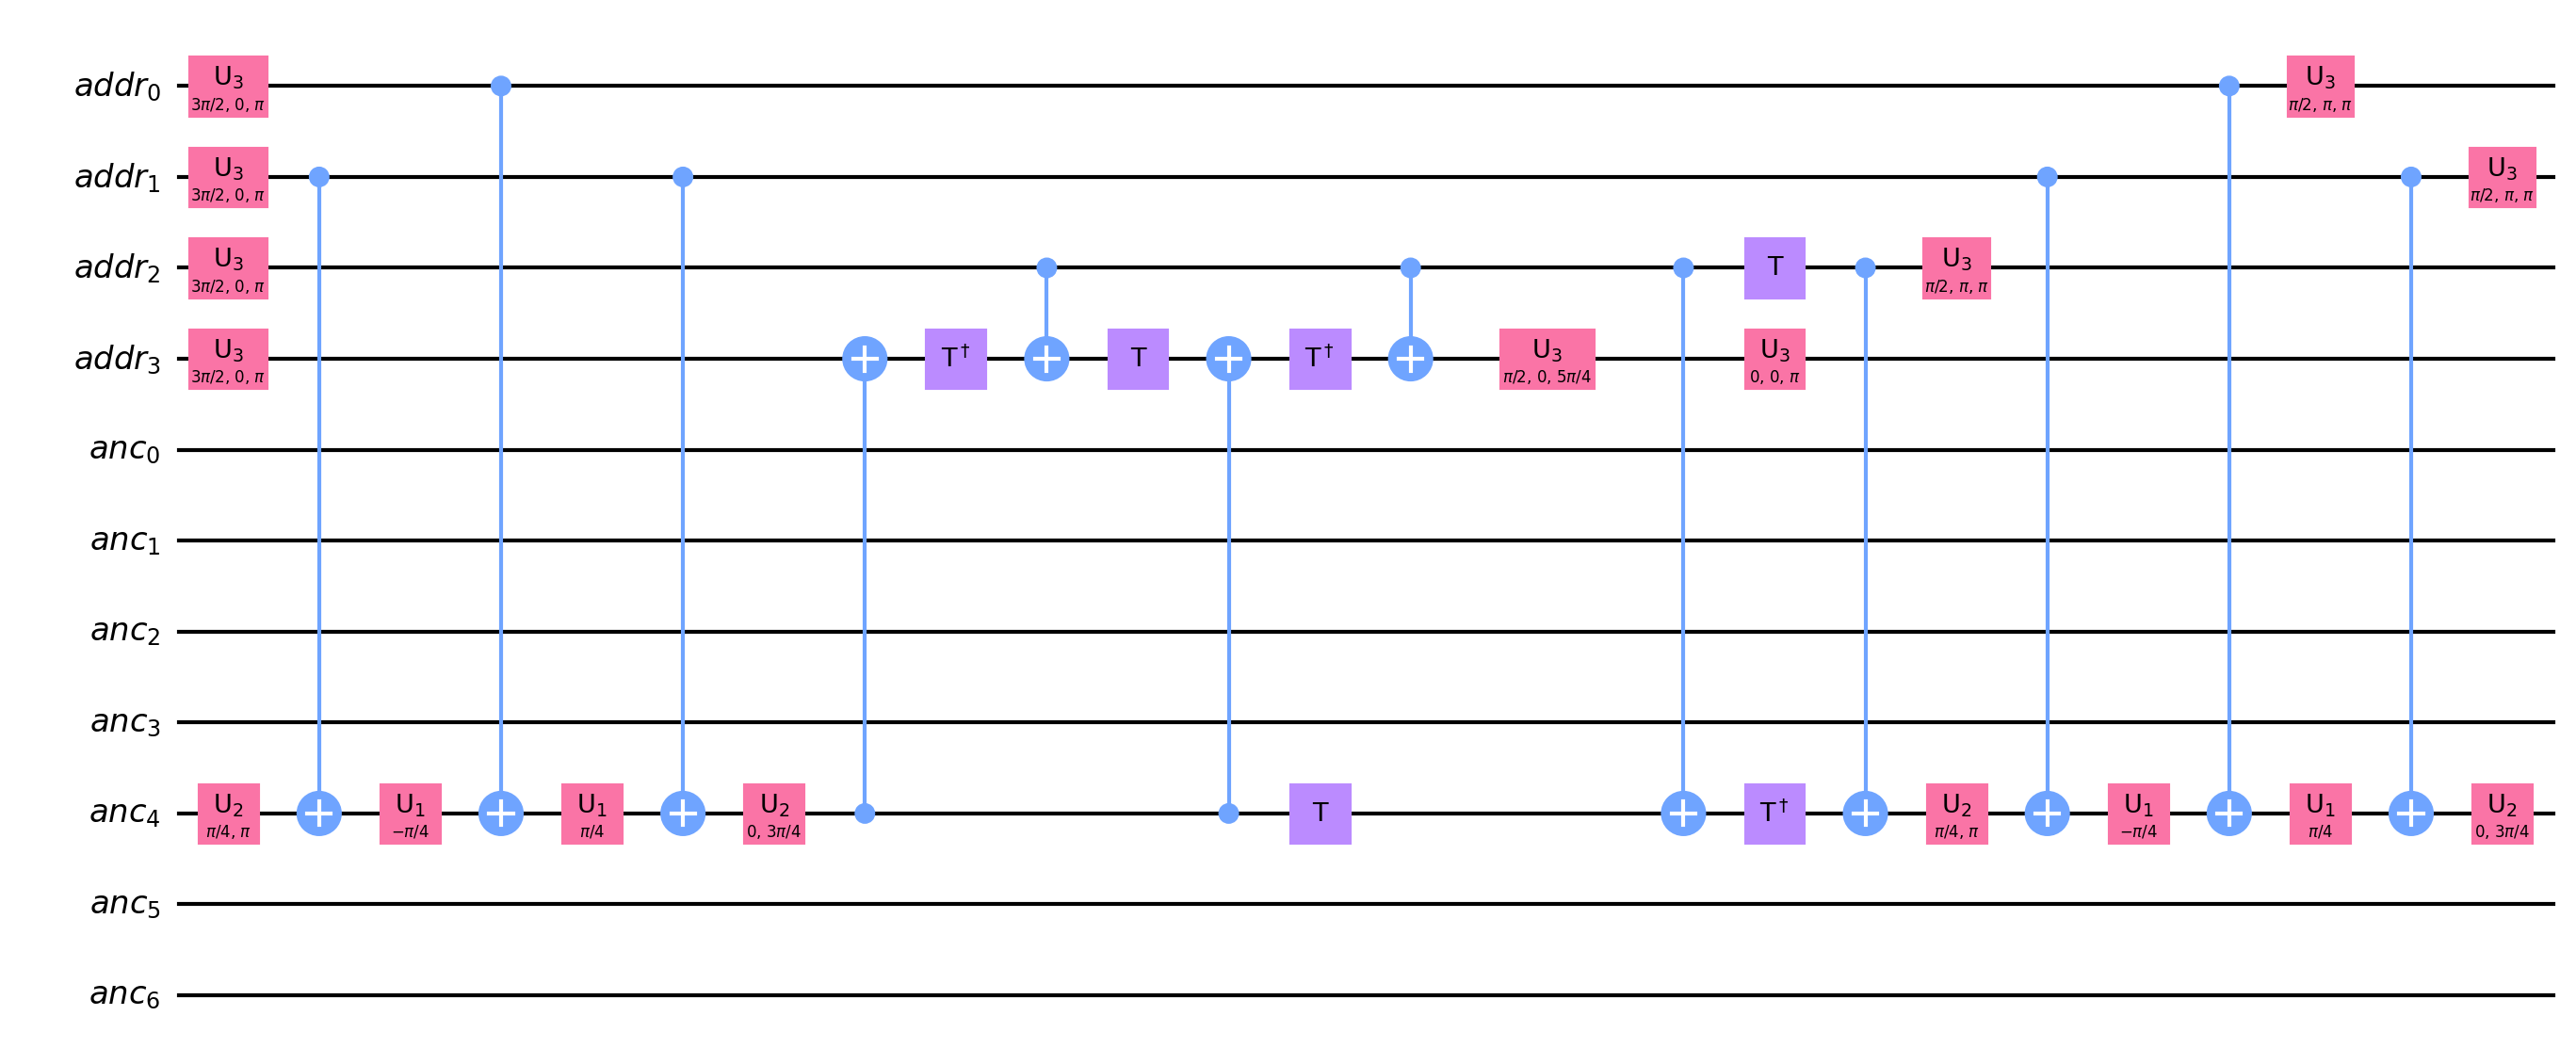

In [18]:
def inversion_about_average() -> QuantumCircuit:
    qr = QuantumRegister(4, name="addr")
    qanc = QuantumRegister(7, name='anc')
    qc = QuantumCircuit(qr, qanc, name='inversion')

    qc.append(U3Gate(3*pi/2, 0, pi), [qr[0]], [])  # -X-H-X-
    qc.append(U3Gate(3*pi/2, 0, pi), [qr[1]], [])  # -X-H-X-
    qc.append(U3Gate(3*pi/2, 0, pi), [qr[2]], [])  # -X-H-X-
    qc.append(U3Gate(3*pi/2, 0, pi), [qr[3]], [])  # -X-H-X-

    #qc.h(qr[3])                                cancels v

    my_rccx(qc, qr[0], qr[1], qanc[4])

    # my_ccx(qc, qr[2], qanc[4], qr[3])
    #qc.append(HGate(),  [qr[3]], [])           cancels ^
    qc.append(CXGate(),  [qanc[4], qr[3]], [])
    qc.append(TdgGate(),          [qr[3]], [])
    qc.append(CXGate(),    [qr[2], qr[3]], [])
    qc.append(TGate(),            [qr[3]], [])
    qc.append(CXGate(),  [qanc[4], qr[3]], [])
    qc.append(TdgGate(),          [qr[3]], [])
    qc.append(CXGate(),    [qr[2], qr[3]], [])
    qc.append(TGate(),          [qanc[4]], [])

    qc.append(U3Gate(pi / 2, 0, 5 * pi / 4), [qr[3]], [])  # -T-H-

    qc.append(CXGate(), [qr[2], qanc[4]], [])
    qc.append(TGate(),           [qr[2]], [])
    qc.append(TdgGate(),       [qanc[4]], [])
    qc.append(CXGate(), [qr[2], qanc[4]], [])

    my_rccx(qc, qr[0], qr[1], qanc[4])

    qc.append(U3Gate(   0,  0, pi), [qr[3]], [])  # -H-X-H-
    qc.append(U3Gate(pi/2, pi, pi), [qr[2]], [])  # -X-H-
    qc.append(U3Gate(pi/2, pi, pi), [qr[1]], [])  # -X-H-
    qc.append(U3Gate(pi/2, pi, pi), [qr[0]], [])  # -X-H-

    return qc

## QRAM

The QRAM encodes the 16 boards the way we learned in _Week 2b_. It also exploits the [Gray code](https://en.wikipedia.org/wiki/Gray_code) to minimize changed bits between two addresses and therefore  the number of multi-controlled X gates.

The qubit `qanc[6]` is not immediately uncomputed and retains it state until the QRAM ist uncomputed as a whole after the oracle.

The following figure illustrates how the first six boards are put in the QRAM.

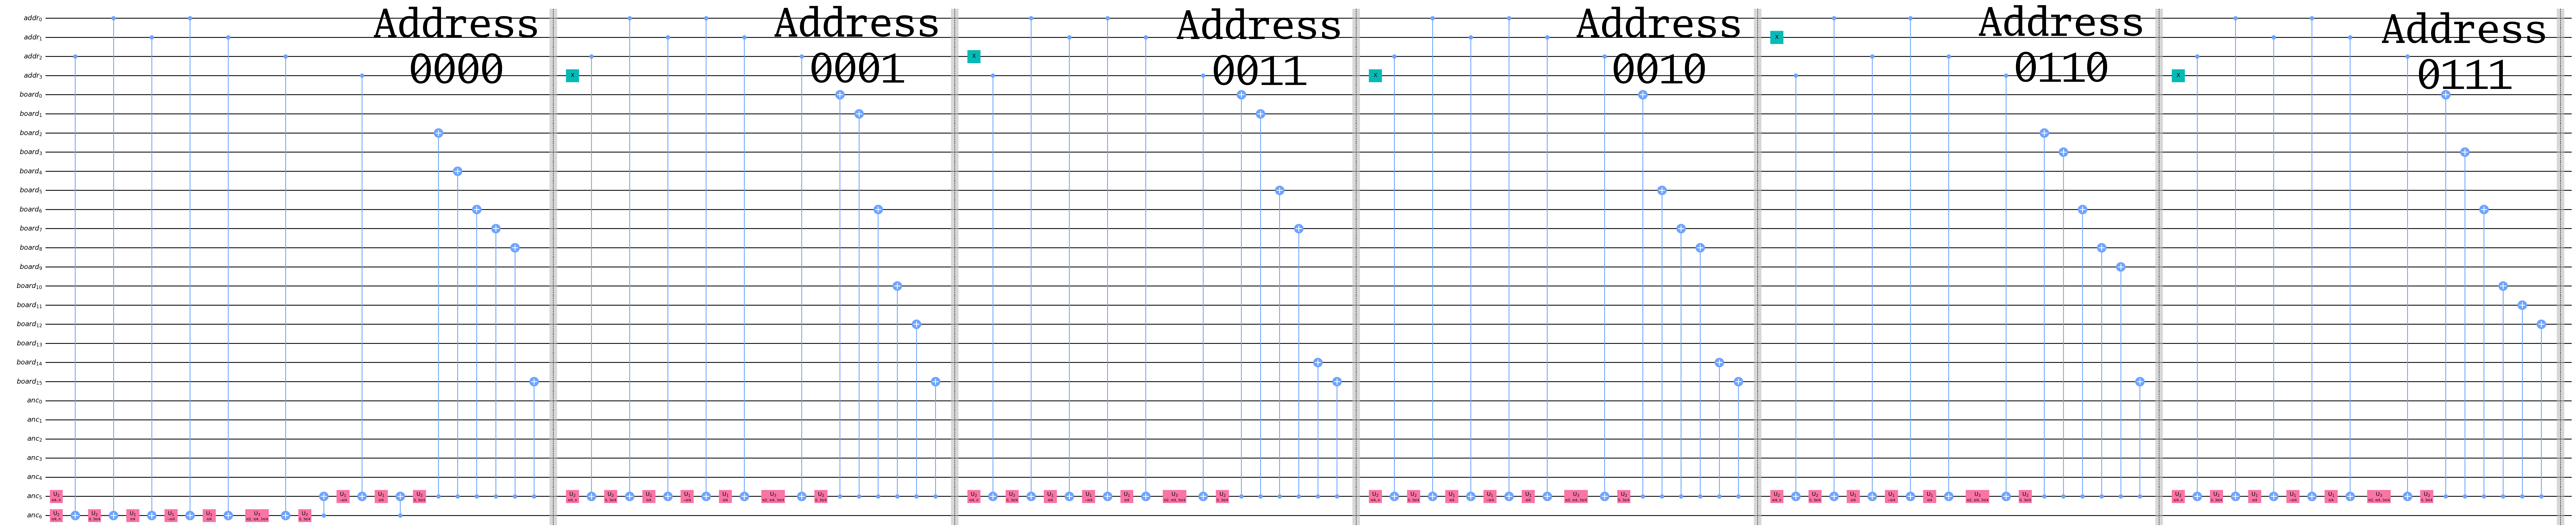

In [19]:
def qram(problemset, debug=False):
    qaddr = QuantumRegister(4, 'addr')
    qboard = QuantumRegister(16, 'board')
    qanc = QuantumRegister(7, 'anc')
    qc = QuantumCircuit(qaddr, qboard, qanc, name='qram')

    # 0000 First Memory Cell
    # qc.x(qaddr) fused with initial hadamards and diffusion

    #qc.mcx(qaddr, qanc[6], ancilla_qubits=qanc, mode='v-chain')
    my_rcccx(qc, qaddr[0], qaddr[1], qaddr[2], qanc[6])
    my_rccx(qc, qaddr[3], qanc[6], qanc[5])

    for index, [row, column] in enumerate(problemset[0]):
        row = int(row)
        column = int(column)
        qc.cx(qanc[5], qboard[row * 4 + column])

    gray_codes = GrayCode(4).generate_gray()
    prev_gray: str = next(gray_codes)
    if debug: qc.barrier()
    for current_gray in gray_codes:
        current_index: int = int(current_gray, 2)
        addr_bits = [qaddr[i] for i in range(4) if current_gray[i] == prev_gray[i]]
        change_bit = [qaddr[i] for i in range(4) if current_gray[i] != prev_gray[i]]
        assert len(addr_bits) == 3 and len(change_bit) == 1

        qc.x(change_bit)
        my_rcccx(qc, *addr_bits, qanc[5])

        for index, [row, column] in enumerate(problemset[current_index]):
            row = int(row)
            column = int(column)
            qc.cx(qanc[5], qboard[row * 4 + column])

        prev_gray = current_gray
        if debug: qc.barrier()
    return qc

## Oracle

Some possibly interesting numbers: There are $\binom{16}{6} = 8008$ possible $4\times 4$ boards with $6$ asteroids (including rotation and mirroring). Of these, $1512$ are not solvable.

The approach I took to solve the challenge is based on identifying the unsolvable boards by checking if the rows/columns can be exchanged to get a diagonal. For the diagonal only 4 asteroids are required. This amounts to $4!=24$ checks with 4 controls. (The first column has 4 possible cells, the next one has only 3 as one row is covered by the check in the first column, leaving 2 choices for the 3rd column, and one choice for the last.)

Unfornately, there are 72 boards with two possible sets of exchanges resulting in a diagonal. Having "two diagonals" would cancel the phase, leading to a wrong solution. This is corrected by not flipping the phase, i.e., rotating by $\pi$, but only rotating by $\frac{3}{4}\pi$, so reliable results are attained in either case.

The costs can be further reduced by ordering the checks such that only two cells change between each check, causing the gates to partially cancel out.

The first three of 24 checks are illustrated below.

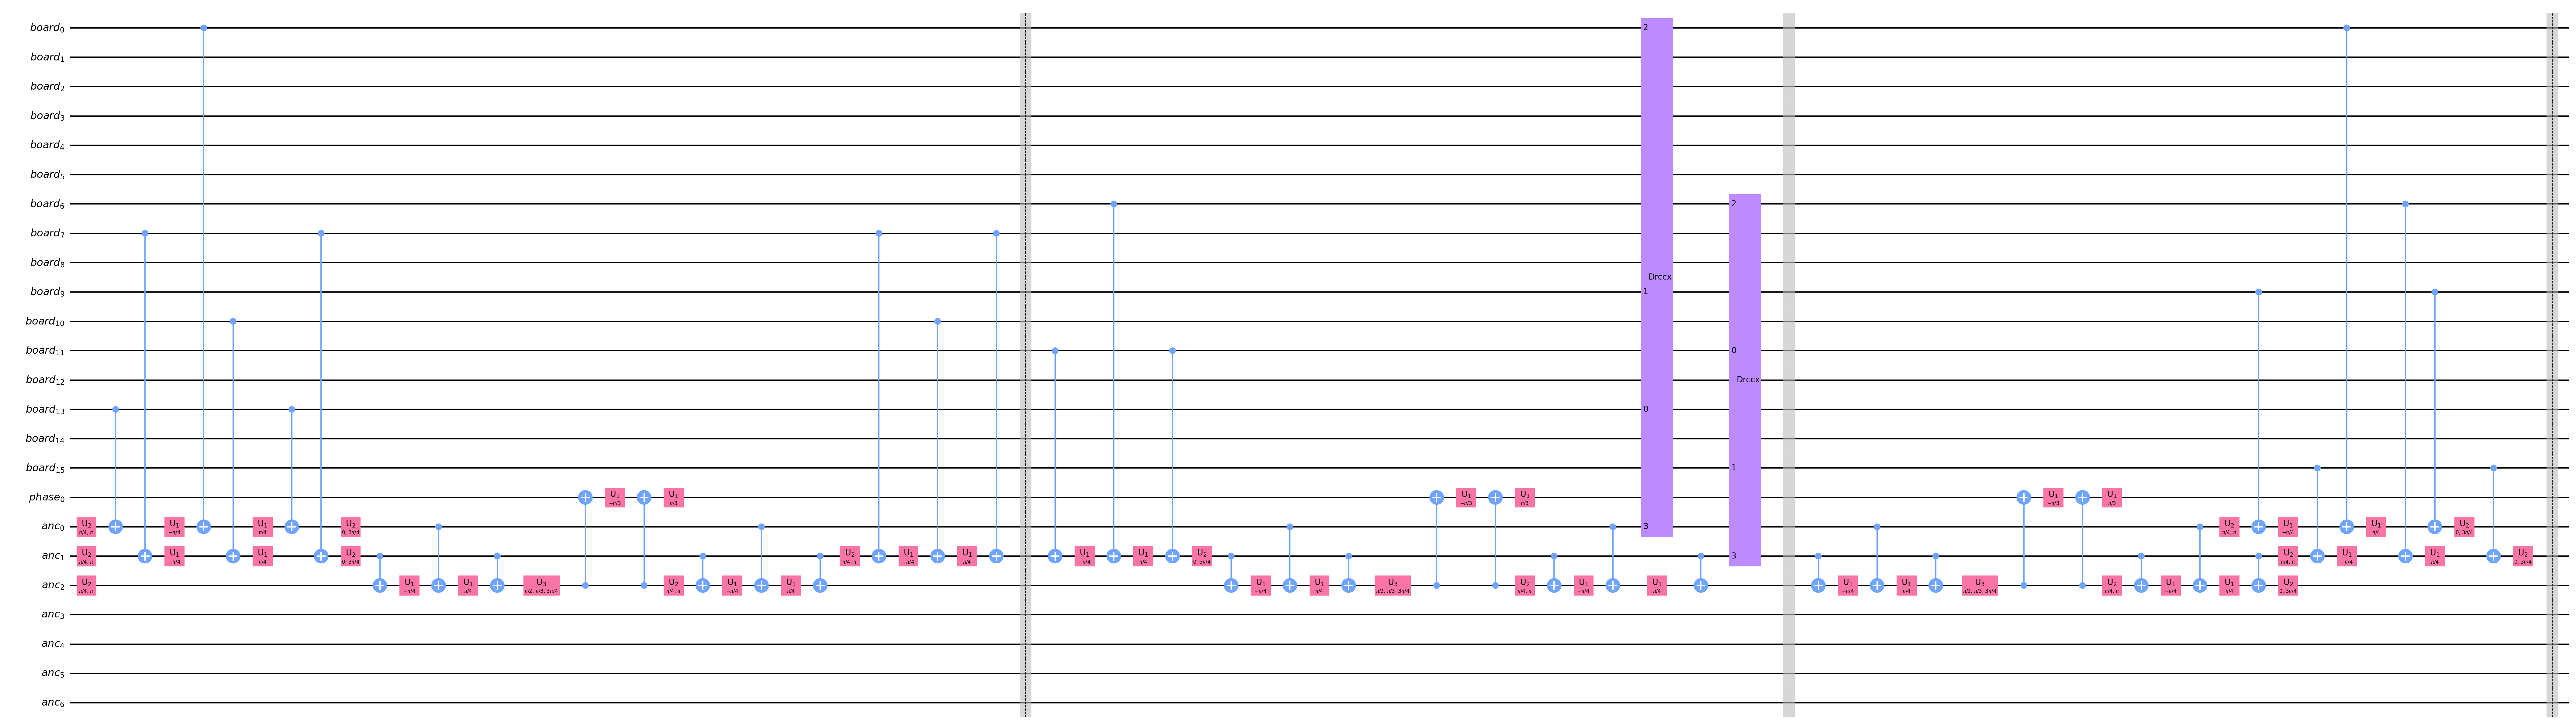

In [20]:
def oracle() -> QuantumCircuit:
    qaddr = QuantumRegister(4, 'address')
    qboard = QuantumRegister(16, 'board')
    qphase = QuantumRegister(1, 'phase')
    qanc = QuantumRegister(7, 'anc')
    qc = QuantumCircuit(qaddr, qboard, qphase, qanc, name='oracle')

    # list(multiset_permutations([0, 1, 2, 3])) with some preprocessing and better order
    d = [[-1, -1, -1, -1],
         [ 0, 13, 10,  7],
         [ 0, 13,  6, 11],
         [ 0,  9,  6, 15],
         [ 0,  9, 14,  7],
         [ 0,  5, 14, 11],
         [ 0,  5, 10, 15],
         [ 4,  1, 10, 15],
         [ 4,  1, 14, 11],
         [ 4,  9, 14,  3],
         [ 4,  9,  2, 15],
         [ 4, 13,  2, 11],
         [ 4, 13, 10,  3],
         [12,  5, 10,  3],
         [12,  5,  2, 11],
         [12,  1,  6, 11],
         [12,  1, 10,  7],
         [12,  9,  2,  7],
         [12,  9,  6,  3],
         [ 8, 13,  6,  3],
         [ 8, 13,  2,  7],
         [ 8,  1, 14,  7],
         [ 8,  1,  6, 15],
         [ 8,  5,  2, 15],
         [ 8,  5, 14,  3],
         [-1, -1, -1, -1]]

    for i in range(1, len(d)-1):
        if (d[i][0] != d[i-1][0]) and (d[i][1] != d[i-1][1]):
            #my_rccx(qc, qboard[d[i][0]], qboard[d[i][1]], qanc[0])
            if i == 1:
                qc.append(U2Gate(pi / 4, pi),    [qanc[0]], []),  # -H-T-
            qc.append(CXGate(), [qboard[d[i][1]], qanc[0]], []),
            qc.append(U1Gate(-pi / 4),           [qanc[0]], []),  # inverse T gate
            qc.append(CXGate(), [qboard[d[i][0]], qanc[0]], []),
            qc.append(U1Gate(pi / 4),            [qanc[0]], []),
            qc.append(CXGate(), [qboard[d[i][1]], qanc[0]], []),
            qc.append(U2Gate(0, 3*pi/4),         [qanc[0]], []),  # -Tdg-H-

        if (d[i][2] != d[i-1][2]) and (d[i][3] != d[i-1][3]):
            #my_rccx(qc, qboard[d[i][2]], qboard[d[i][3]], qanc[1])
            if i == 1:
                qc.append(U2Gate(pi / 4, pi),    [qanc[1]], []),  # -H-T-
            qc.append(CXGate(), [qboard[d[i][3]], qanc[1]], []),
            qc.append(U1Gate(-pi / 4),           [qanc[1]], []),  # inverse T gate
            qc.append(CXGate(), [qboard[d[i][2]], qanc[1]], []),
            qc.append(U1Gate(pi / 4),            [qanc[1]], []),
            qc.append(CXGate(), [qboard[d[i][3]], qanc[1]], []),
            qc.append(U2Gate(0, 3*pi/4),         [qanc[1]], []),  # -Tdg-H-


        #my_rccx(qc, qanc[0], qanc[1], qanc[2])
        if (d[i][2] != d[i - 1][2]) or (d[i][3] != d[i - 1][3]):
            if i == 1:
                qc.append(U2Gate(pi/4, pi),       [qanc[2]], []),  # -H-T-
            qc.append(CXGate(),      [qanc[1], qanc[2]], []),
            qc.append(U1Gate(-pi / 4),        [qanc[2]], []),  # inverse T gate
        qc.append(CXGate(),      [qanc[0], qanc[2]], []),
        qc.append(U1Gate(pi / 4),         [qanc[2]], []),
        qc.append(CXGate(),      [qanc[1], qanc[2]], []),
        #qc.append(U2Gate(0, 3*pi/4),      [qanc[2]], []),  # -Tdg-H-

        qc.append(U3Gate(pi / 2, 3 / 8 * pi, 3 / 4 * pi), [qanc[2]], [])  # -Tdg-H-U1-

        #qc.append(U1Gate(3*pi/8),    [qanc[2]], [])
        qc.append(CXGate(), [qanc[2], qphase], [])
        qc.append(U1Gate(-3 * pi / 8), [qphase], [])
        qc.append(CXGate(), [qanc[2], qphase], [])
        qc.append(U1Gate(3 * pi / 8), [qphase], [])

        #my_rccx(qc, qanc[0], qanc[1], qanc[2])
        qc.append(U2Gate(pi/4, pi),       [qanc[2]], []),  # -H-T-
        qc.append(CXGate(),      [qanc[1], qanc[2]], []),
        qc.append(U1Gate(-pi / 4),        [qanc[2]], []),  # inverse T gate
        qc.append(CXGate(),      [qanc[0], qanc[2]], []),
        if (d[i][2] != d[i + 1][2]) or (d[i][3] != d[i + 1][3]):
            qc.append(U1Gate(pi / 4),         [qanc[2]], []),
            qc.append(CXGate(),      [qanc[1], qanc[2]], []),
            if i == len(d)-2:
                qc.append(U2Gate(0, 3*pi/4),      [qanc[2]], []),  # -Tdg-H-


        if (d[i][2] != d[i+1][2]) and (d[i][3] != d[i+1][3]):
            #my_rccx(qc, qboard[d[i][2]], qboard[d[i][3]], qanc[1])
            qc.append(U2Gate(pi / 4, pi),        [qanc[1]], []),  # -H-T-
            qc.append(CXGate(), [qboard[d[i][3]], qanc[1]], []),
            qc.append(U1Gate(-pi / 4),           [qanc[1]], []),  # inverse T gate
            qc.append(CXGate(), [qboard[d[i][2]], qanc[1]], []),
            qc.append(U1Gate(pi / 4),            [qanc[1]], []),
            qc.append(CXGate(), [qboard[d[i][3]], qanc[1]], []),
            if i == len(d) - 2:
                qc.append(U2Gate(0, 3*pi/4),         [qanc[1]], []),  # -Tdg-H-
        elif (d[i][2] != d[i+1][2]) or (d[i][3] != d[i+1][3]):
            if d[i][2] == d[i + 1][2]:
                same_idx = 2
                diff_idx = 3
            else:
                same_idx = 3
                diff_idx = 2

            my_drccx(qc, qboard[d[i][diff_idx]], qboard[d[i + 1][diff_idx]], qboard[d[i][same_idx]], qanc[1])

        if (d[i][0] != d[i+1][0]) and (d[i][1] != d[i+1][1]):
            #my_rccx(qc, qboard[d[i][0]], qboard[d[i][1]], qanc[0])
            qc.append(U2Gate(pi / 4, pi),        [qanc[0]], []),  # -H-T-
            qc.append(CXGate(), [qboard[d[i][1]], qanc[0]], []),
            qc.append(U1Gate(-pi / 4),           [qanc[0]], []),  # inverse T gate
            qc.append(CXGate(), [qboard[d[i][0]], qanc[0]], []),
            qc.append(U1Gate(pi / 4),            [qanc[0]], []),
            qc.append(CXGate(), [qboard[d[i][1]], qanc[0]], []),
            if i == len(d) - 2:
                qc.append(U2Gate(0, 3*pi/4),         [qanc[0]], []),  # -Tdg-H-

        elif (d[i][0] != d[i+1][0]) or (d[i][1] != d[i+1][1]):
            if d[i][0] == d[i+1][0]:
                same_idx = 0
                diff_idx = 1
            else:
                same_idx = 1
                diff_idx = 0
            my_drccx(qc, qboard[d[i][diff_idx]], qboard[d[i+1][diff_idx]], qboard[d[i][same_idx]], qanc[0])
    return qc

## Combining the Building Blocks

Given the diffusion, the qram, and the oracle, the building blocks only have to be put together. Only the qram depends on on having additional `X` gates on `qaddr` incorporated in the beginning below and in the diffusion.

The 28 qubits are used as follows:
- 4 address qubits `qaddr`
- 16 data qubits for the QRAM `qboard` 
- 1 qubit to flip the phase `qpp`
- 7 ancillary qubits `qanc`

And, of course, 4 classical bits for the measurement result.

In [21]:
def week3_ans_func(problemset) -> QuantumCircuit:
    qaddr = QuantumRegister(4, 'addr')
    qboard = QuantumRegister(16, 'board')
    qpp = QuantumRegister(1, 'phase')
    qanc = QuantumRegister(7, 'anc')
    caddr = ClassicalRegister(4, 'caddr')
    qc = QuantumCircuit(qaddr, qboard, qpp, qanc, caddr)

    qc.append(U3Gate(pi/2, 0,  0), [qaddr[0]], [])  # -H-X-
    qc.append(U3Gate(pi/2, 0,  0), [qaddr[1]], [])  # -H-X-
    qc.append(U3Gate(pi/2, 0,  0), [qaddr[2]], [])  # -H-X-
    qc.append(U3Gate(pi/2, 0,  0), [qaddr[3]], [])  # -H-X-
    qc.append(U3Gate(  pi, 0, pi),      [qpp], [])
    #qc.barrier()

    for _ in range(1):
        # qram
        qc.append(qram(problemset).to_gate(), [*qaddr, *qboard, *qanc])
        # oracle
        qc.append(oracle().to_gate(), [*qaddr, *qboard, *qpp, *qanc])
        # uncomputing qram
        qc.append(qram(problemset).to_gate().inverse(), [*qaddr, *qboard, *qanc])
        # diffusion
        qc.append(inversion_about_average().to_gate(), [*qaddr, *qanc])

    qc.measure(qaddr, caddr)

    return qc

## Costs

The circuit has costs of 8188, regardless of the input.

In [22]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# original problem set
q0 = [[['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
       [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
       [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
       [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
       [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
       [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
       [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
       [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
       [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
       [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
       [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
       [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
       [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
       [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
       [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
       [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']]]

qc = week3_ans_func(q0)

pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)
ops = new_circuit.count_ops()
print('Score: 10x{} + {} = {}'.format(ops['cx'], ops['u3'], 10*ops['cx']+ops['u3']))

Score: 10x754 + 648 = 8188


The resulting measurements in the submission were as follows:

```
{'0000': 36,
 '0001': 43,
 '0010': 45,
 '0011': 37,
 '0100': 46,
 '0101': 411,
 '0110': 32,
 '0111': 48,
 '1000': 44,
 '1001': 30,
 '1010': 41,
 '1011': 37,
 '1100': 34,
 '1101': 34,
 '1110': 43,
 '1111': 39}
 ```